In [3]:
import sys
import numpy as np
import random as rn
import pandas as pd
import os
import re
import time
import random
import heapq
import gc
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

path = '/vol/fob-vol7/nebenf21/rohjehyu/Downloads/'
import torch
from pytorch_pretrained_bert import BertModel
from torch import nn
from pytorch_pretrained_bert import BertTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score,f1_score, precision_score, recall_score

import scipy as sp
from scipy.stats import entropy
from scipy.spatial import distance
from scipy.spatial import distance_matrix
from statistics import mean


2022-06-25 21:52:15.424340: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Code References:
Adapted the codes from 
Uncertainty Sampling, Coreset Sampling , Diversity in Feature Space and Representativeness
https://github.com/IBM/low-resource-text-classification-framework/tree/4380755a65b35265e84ecbf4b87e872d79e8f079#reference
(Active Learning for {BERT}: An Empirical Study)
where the sampling stategies parts are adapted from
https://github.com/dsgissin/DiscriminativeActiveLearning
(Discriminative Active Learning)

In [4]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

Quadro RTX 6000
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [5]:
#setting the initial seed
rn.seed(555)
np.random.seed(555)
torch.manual_seed(555)
torch.cuda.manual_seed(555)

In [4]:
#For saving the files later, selecting which seed and dataset I ran
name='isot'
seed='111'

In [5]:
#Load Kaggle Fake News dataset
kaggle=pd.read_csv(path + 'Kaggle_may.csv', encoding="UTF-8")

kaggle=kaggle[['text','labels']] 

In [4]:
#Load PolitiFact dataset
politifact=pd.read_csv(path + 'Politifact_may.csv', encoding="UTF-8")
politifact=politifact[['text','labels']] 

In [4]:
#Load Combined Corpus dataset
cc=pd.read_csv(path + 'CC_may.csv', encoding="UTF-8")
cc=cc[['text','labels']]

In [4]:
#Load Covid-19 Fake News dataset
covid=pd.read_csv(path+'Covid_may.csv', encoding="UTF-8")
covid=covid[['text','labels']]

In [6]:
#Load ISOT dataset
isot=pd.read_csv(path+'ISOT_may.csv', encoding="UTF-8")
isot=isot[['text','labels']] 

In [7]:
isot

,text,labels
0,donald trump sends out embarrassing new year ...,1
1,drunk bragging trump staffer started russian ...,1
2,sheriff david clarke becomes an internet joke...,1
3,trump is so obsessed he even has obama name c...,1
4,pope francis just called out donald trump dur...,1
...,...,...
44914,'fully committed' nato backs new united states...,0
44915,lexisnexis withdrew two products from chinese ...,0
44916,minsk cultural hub becomes haven from authorit...,0
44917,vatican upbeat on possibility of pope francis ...,0


In [7]:
gc.collect()
torch.cuda.empty_cache()

#Select the dataset, here ISOT dataset is selected
df=isot
df=df.dropna()
df=df.drop_duplicates(subset=['text', 'labels'], keep='last')

#train, test split is 7:3
TEST_SIZE=0.3

#If dataset is bigger than 15000 instances, randomly select 15000 instances
if len(df)>15000:
    df = df.sample(15000).reset_index(drop=True)


#Split train, test data
train_data, test_data = train_test_split(df, test_size=TEST_SIZE)

#Convert the DataFrame to a dictionary.
train_data = train_data.to_dict(orient='records')
test_data = test_data.to_dict(orient='records')

train_texts, train_labels = list(zip(*map(lambda d: (d['text'], d['labels']), train_data)))
test_texts, test_labels = list(zip(*map(lambda d: (d['text'], d['labels']), test_data)))

#Tokenizing and Padding sequences
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], train_texts))
test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], test_texts))
train_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, train_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")
test_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, test_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")
train_y = np.array(train_labels) == 1
test_y = np.array(test_labels) == 1
train_masks = [[float(i > 0) for i in ii] for ii in train_tokens_ids]
test_masks = [[float(i > 0) for i in ii] for ii in test_tokens_ids]

#Defining the Bert model using 'bert-base-uncased' pretrained model. 
class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertBinaryClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')

        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.dropout2 = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, tokens, masks=None):
        _, pooled_output = self.bert(tokens, attention_mask=masks, output_all_encoded_layers=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        dropout_output2= self.dropout2(linear_output)
        proba = self.sigmoid(dropout_output2)
        return proba
    
    
#Initializing the Bert model and connect to gpu
def bert_initialize():
    # ensuring that the model runs on GPU, not on CPU
    bert_clf = BertBinaryClassifier()
    bert_clf = bert_clf.cuda()     # running BERT on CUDA_GPU
    return bert_clf
bert_clf=bert_initialize()


# Setting hyper-parameters and connecting it to torch tensors and making a DataLoader.

BATCH_SIZE = 4
EPOCHS = 5
train_tokens_tensor = torch.tensor(train_tokens_ids)
train_y_tensor = torch.tensor(train_y.reshape(-1, 1)).float()

test_tokens_tensor = torch.tensor(test_tokens_ids)
test_y_tensor = torch.tensor(test_y.reshape(-1, 1)).float()

train_masks_tensor = torch.tensor(train_masks)
test_masks_tensor = torch.tensor(test_masks)

train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

#defining optimizers
param_optimizer = list(bert_clf.sigmoid.named_parameters()) 
optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
optimizer = Adam(bert_clf.parameters(), lr=3e-6)

torch.cuda.empty_cache()   # Clearing Cache space for a fresh Model run


#function to convert array to Loader
def array_to_loader(_tokens_ids,_y,_masks,BATCH_SIZE,sampler):
    _tokens_tensor = torch.tensor(_tokens_ids)
    _y_tensor = torch.tensor(_y.reshape(-1, 1)).float()
    _masks_tensor = torch.tensor(_masks)
    
    _dataset = TensorDataset(_tokens_tensor, _masks_tensor, _y_tensor)
    _sampler = sampler(_dataset)
    _dataloader = DataLoader(_dataset, sampler=_sampler, batch_size=BATCH_SIZE)
    return _dataloader



#This is to select first 100 samples randomly but stratified according to the original dataset label ratio
def initialize(_tokens_ids,_y,_masks,num,BATCH_SIZE):  
    idx_False=np.where(_y == False)[0]
    idx_True=np.where(_y== True)[0]
    k=int(len(np.where(_y == False)[0])/len(_y)*100) #this is the percentage of the original dataset
    
    initial_False=random.sample(idx_False.tolist(),k) 
    initial_True=random.sample(idx_True.tolist(),num-k)
    
    idx_initial=initial_False+initial_True
    idx_pool=[x for x in list(np.arange(0,len(_y))) if (x not in idx_initial)]
    
    initial_tokens_ids=_tokens_ids[idx_initial]
    initial_y=_y[idx_initial]  
    initial_masks=[_masks[i] for i in idx_initial]
    
    pool_tokens_ids=_tokens_ids[idx_pool]
    pool_y=_y[idx_pool]
    pool_masks=[_masks[i] for i in idx_pool]
    
    initial_dataloader=array_to_loader(initial_tokens_ids,initial_y,initial_masks,BATCH_SIZE,RandomSampler)
    pool_dataloader=array_to_loader(pool_tokens_ids,pool_y,pool_masks,BATCH_SIZE,SequentialSampler)    
    return initial_dataloader, pool_dataloader,initial_tokens_ids,pool_tokens_ids,initial_masks,pool_masks,initial_y,pool_y

#Training the BERT model
def train(dataloader,EPOCH):
    gc.collect()
    
    bert_clf=bert_initialize() #Initialize the model and connect to gpu
    
    param_optimizer = list(bert_clf.sigmoid.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
    optimizer = Adam(bert_clf.parameters(), lr=3e-6)
    torch.cuda.empty_cache()   # Clearing Cache space for a fresh Model run
    
    for epoch_num in range(EPOCH):
        bert_clf.train()
        train_loss = 0
        for step_num, batch_data in enumerate(dataloader):
            token_ids, masks, labels = tuple(t.to(device) for t in batch_data)
            logits = bert_clf(token_ids, masks)
        
            loss_func = nn.BCELoss()

            batch_loss = loss_func(logits, labels)
            train_loss += batch_loss.item()
        
            bert_clf.zero_grad()
            batch_loss.backward()
            clip_grad_norm_(parameters=bert_clf.parameters(), max_norm=1.0)
            optimizer.step()
            numpy_logits = logits.cpu().detach().numpy()
            clear_output(wait=True)
            print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(train_data) / BATCH_SIZE, train_loss / (step_num + 1)))
    return bert_clf #returned a bert model that is trained with the input dataset


#Evaluating the performance using accuracy, precision, recall and f1 score
def eval_(bert_clf,dataloader,results_p,results_r,results_f,results_a,_y):
    bert_clf.eval()
    bert_predicted = []
    all_logits = []
    train_loss = 0
    step_num=0
    with torch.no_grad():
        for step_num, batch_data in enumerate(dataloader):

            token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

            logits = bert_clf(token_ids, masks)
            loss_func = nn.BCELoss()
            loss = loss_func(logits, labels)
            train_loss += loss.item()
            numpy_logits = logits.cpu().detach().numpy()
        
            bert_predicted += list(numpy_logits[:, 0] > 0.5)
            all_logits += list(numpy_logits[:, 0])
            clear_output(wait=True)
            print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(train_data) / BATCH_SIZE, train_loss / (step_num + 1)))
        #Saving test resutls using different metrics
        results_p.append(precision_score(_y,bert_predicted))
        results_r.append(recall_score(_y,bert_predicted))
        results_f.append(f1_score(_y,bert_predicted))
        results_a.append(accuracy_score(_y,bert_predicted))
    return results_p,results_r,results_f,results_a,all_logits

##Random Sampling
def randomsampling(logits,query_num): 
    idx_query = [i for i in range(len(logits))]
    idx_query=random.sample(idx_query,query_num)  #randomly selecting indexes
    return idx_query

##Uncertainty Sampling
def uncertaintysampling(bert_clf,dataloader,query_num):
    bert_clf.eval() 
    all_logits = []
    step_num=0
    with torch.no_grad():
        for step_num, batch_data in enumerate(dataloader):

            token_ids, masks, _ = tuple(t.to(device) for t in batch_data)
            logits = bert_clf(token_ids, masks)
            numpy_logits = logits.cpu().detach().numpy()
            all_logits += list(numpy_logits[:, 0])
        
    pool_uncertainty=[1-x if x>=0.5 else x for x in all_logits] #making everything equal or under to 0.5
    idx_query=np.argpartition(pool_uncertainty, -query_num)[-query_num:].tolist() #samples close to 0.5 are chosen
    return idx_query

## Dropout Sampling
def Dropout(iter_num,pool_y,bert_clf,dataloader,query_num):
    bert_clf.train()
    logitarray=np.zeros((10,len(pool_y),1))

    for t in range(iter_num):#for 10 iterations. iter_num=10. evaluation mode. 
        logitss=[]    
        with torch.no_grad():
            for step_num, batch_data in enumerate(dataloader):
                token_ids, masks, _ = tuple(t.to(device) for t in batch_data)
                logits = bert_clf(token_ids, masks).cpu().detach().numpy()
                logitss+=list(logits[:, 0])
        logitarray[t,:,:]=np.stack(logitss, axis=0).reshape(-1,1)
    logitlist=np.mean(logitarray,axis=0)[:,0].tolist() #averaging the logits acquired in the 10 iterations
    pool_uncertainty=[1-x if x>=0.5 else x for x in logitlist] #making everything equal or under to 0.5
    idx_query=np.argpartition(pool_uncertainty, -query_num)[-query_num:].tolist() #selecting samples close to 0.5
    return idx_query

def array_to_loader2(_tokens_ids,_y,BATCH_SIZE,sampler):
    _tokens_tensor = torch.tensor(_tokens_ids)
    _y_tensor = torch.tensor(_y.reshape(-1, 1)).float()
    
    _dataset = TensorDataset(_tokens_tensor, _y_tensor)
    _sampler = sampler(_dataset)
    _dataloader = DataLoader(_dataset, sampler=_sampler, batch_size=BATCH_SIZE)
    return _dataloader

##Coreset Sampling
def CoreSet(train_tokens_ids,pool_tokens_ids,query_num):
    greedy_indices = [] #using k-center-greedy algorithm.
    # get the minimum distances between the labeled and unlabeled examples 
    min_dist = np.min(distance_matrix(train_tokens_ids[0, :].reshape((1, train_tokens_ids.shape[1])), pool_tokens_ids), axis=0)
    min_dist = min_dist.reshape((1, min_dist.shape[0]))
    for j in range(1, train_tokens_ids.shape[0], 100):
        if j + 100 < train_tokens_ids.shape[0]:
            dist = distance_matrix(train_tokens_ids[j:j+100, :], pool_tokens_ids)
        else:
            dist = distance_matrix(train_tokens_ids[j:, :], pool_tokens_ids)
            min_dist = np.vstack((min_dist, np.min(dist, axis=0).reshape((1, min_dist.shape[1]))))
            min_dist = np.min(min_dist, axis=0)
            min_dist = min_dist.reshape((1, min_dist.shape[0]))   

    farthest = np.argmax(min_dist)
    greedy_indices.append(farthest)
    for i in range(query_num-1):
        dist = distance_matrix(pool_tokens_ids[greedy_indices[-1], :].reshape((1,pool_tokens_ids.shape[1])), pool_tokens_ids)
        min_dist = np.vstack((min_dist, dist.reshape((1, min_dist.shape[1]))))
        min_dist = np.min(min_dist, axis=0)
        min_dist = min_dist.reshape((1, min_dist.shape[0]))
        farthest = np.argmax(min_dist)
        greedy_indices.append(farthest)
    
    
    return greedy_indices

#get the idx_query(newly selected instances) and return a new train and pool dataloader and details
def query(pool_tokens_ids,pool_y,pool_masks,initial_tokens_ids,initial_y,initial_masks,BATCH_SIZE,query_num,idx_query):   
    query_tokens_ids=pool_tokens_ids[np.array(idx_query)]
    query_y=pool_y[np.array(idx_query)]
    query_masks=[pool_masks[i] for i in idx_query]

    active_tokens_ids=np.concatenate((initial_tokens_ids, query_tokens_ids), axis=0)
    active_y=np.concatenate((initial_y, query_y), axis=0)
    active_masks=initial_masks+query_masks

    idx_pool2=np.array([x for x in list(np.arange(0,len(pool_y))) if x not in idx_query])
    pool2_tokens_ids=pool_tokens_ids[idx_pool2]
    pool2_y=pool_y[idx_pool2]
    pool2_masks=[pool_masks[i] for i in idx_pool2]

    train_dataloader=array_to_loader(active_tokens_ids,active_y,active_masks,BATCH_SIZE,RandomSampler)
    pool_dataloader=array_to_loader(pool2_tokens_ids,pool2_y,pool2_masks,BATCH_SIZE,SequentialSampler)
    return train_dataloader, pool_dataloader, active_tokens_ids,active_y,active_masks,pool2_tokens_ids,pool2_y,pool2_masks

def AL(method,bert_clf,EPOCH,BATCH_SIZE,num_query,QUERY_SIZE,initial_p,initial_r,initial_f,initial_a,initial_pool_dataloader,initial_train_tokens_ids,initial_pool_tokens_ids,initial_train_masks,initial_pool_masks,initial_train_y,initial_pool_y,test_dataloader,test_y):

    pool_dataloader,train_tokens_ids,pool_tokens_ids,train_masks,pool_masks,train_y,pool_y=initial_pool_dataloader,initial_train_tokens_ids,initial_pool_tokens_ids,initial_train_masks,initial_pool_masks,initial_train_y,initial_pool_y
    #different lists to store the evaluation results(precision, recall, f1, accuracy)
    results_p=[]
    results_p+=initial_p
    
    results_r=[]
    results_r+=initial_r
    
    results_f=[]
    results_f+=initial_f
    
    results_a=[]
    results_a+=initial_a
    
    for q in range(num_query): #selecting the AL strategy for the querying part.
        if method =='random':
            idx_query=randomsampling(pool_y,QUERY_SIZE)
        elif method =='uncertainty':
            idx_query=uncertaintysampling(bert_clf,pool_dataloader,QUERY_SIZE)
        elif method =='dropout':
            idx_query=Dropout(10,pool_y,bert_clf,pool_dataloader,QUERY_SIZE)
        else :
            idx_query=CoreSet(train_tokens_ids,pool_tokens_ids,QUERY_SIZE)
        #redefine train and pool after querying    
        train_dataloader,pool_dataloader,train_tokens_ids,train_y,train_masks,pool_tokens_ids,pool_y,pool_masks=query(pool_tokens_ids,pool_y,pool_masks,train_tokens_ids,train_y,train_masks,BATCH_SIZE,QUERY_SIZE,idx_query)
        #train the bert model with the new train data
        bert_clf=train(train_dataloader,EPOCH)
        #evaluate the performance with the test data
        results_p,results_r,results_f,results_a,_=eval_(bert_clf,test_dataloader,results_p,results_r,results_f,results_a,test_y)
    
    #saving the collected sample data to later analyze
    np.savetxt(method+'_tokens.txt', train_tokens_ids, fmt='%d') 
    np.savetxt(method+'_y.txt', train_y, fmt='%d') 
    np.savetxt(method+'_pool_tokens.txt', pool_tokens_ids, fmt='%d') 
    np.savetxt(method+'_pool_y.txt', pool_y, fmt='%d') 
    np.savetxt(method+'_masks.txt', train_masks, fmt='%d') 
    
    
    #returning the evaluation results in lists
    return results_p,results_r,results_f, results_a



torch.cuda.empty_cache()   # Clearing Cache space for a fresh Model run


In [9]:
##AL loop for all sampling:
bert_clf=bert_initialize()
#lists to store the result of the initial batch
initial_p=[]
initial_r=[]
initial_f=[]
initial_a=[]

#####parameters
EPOCH=5 
INITIAL_SIZE=100
QUERY_SIZE=100 
BATCH_SIZE=4
num_query=5 
###################AL start##############
#initialiaizng
initial_train_dataloader, initial_pool_dataloader,initial_train_tokens_ids,initial_pool_tokens_ids,initial_train_masks,initial_pool_masks,initial_train_y,initial_pool_y=initialize(train_tokens_ids,train_y,train_masks,INITIAL_SIZE,BATCH_SIZE)
#train the BERT with initial data
bert_clf=train(initial_train_dataloader,EPOCH)
#results of initial batch
initial_p,initial_r,initial_f,initial_a,_=eval_(bert_clf,test_dataloader,initial_p,initial_r,initial_f,initial_a,test_y)
print("precision: {0}, recall: {1}, f1: {2}, accuracy:{3}".format(initial_p,initial_r,initial_f, initial_a))

1124/2625.0 loss: 0.356753059996499 
precision: [0.9737292975442604], recall: [0.842807711319822], f1: [0.9035506094329624], accuracy:[0.9191111111111111]


In [10]:
#Random Sampling
gc.collect()
torch.cuda.empty_cache()
start = time.time()

random_p,random_r,random_f, random_a=AL('random',bert_clf,EPOCH,BATCH_SIZE,num_query,QUERY_SIZE,initial_p,initial_r,initial_f,initial_a,initial_pool_dataloader,initial_train_tokens_ids,initial_pool_tokens_ids,initial_train_masks,initial_pool_masks,initial_train_y,initial_pool_y,test_dataloader,test_y)

end = time.time()
random_temp = end-start

#print results
print("precision: {0} \nrecall: {1} \nf1: {2} \naccuracy:{3}".format(random_p,random_r,random_f, random_a))

1124/2625.0 loss: 0.14364350006025697 
precision: [0.9737292975442604, 0.975736568457539, 0.9801821103374397, 0.9829984544049459, 0.985966735966736, 0.9860103626943005] 
recall: [0.842807711319822, 0.8348986653484923, 0.9045971329708354, 0.9431537320810677, 0.9377162629757786, 0.9406821552150272] 
f1: [0.9035506094329624, 0.8998401704848161, 0.9408740359897172, 0.9626639757820383, 0.9612363820623259, 0.9628130533771819] 
accuracy:[0.9191111111111111, 0.9164444444444444, 0.9488888888888889, 0.9671111111111111, 0.966, 0.9673333333333334]


In [11]:
print(random_temp//60)

15.0


In [12]:
#Uncertainty sampling
gc.collect()
torch.cuda.empty_cache()
start = time.time()

uncertainty_p,uncertainty_r,uncertainty_f, uncertainty_a=AL('uncertainty',bert_clf,EPOCH,BATCH_SIZE,num_query,QUERY_SIZE,initial_p,initial_r,initial_f,initial_a,initial_pool_dataloader,initial_train_tokens_ids,initial_pool_tokens_ids,initial_train_masks,initial_pool_masks,initial_train_y,initial_pool_y,test_dataloader,test_y)

end = time.time()
uncertainty_temp = end-start

#print results
print("precision: {0} \nrecall: {1} \nf1: {2} \naccuracy:{3}".format(uncertainty_p,uncertainty_r,uncertainty_f, uncertainty_a))

1124/2625.0 loss: 0.04999756650792228 
precision: [0.9737292975442604, 0.9598997493734336, 0.9546112988894254, 0.9897074756229686, 0.9841033283656234, 0.9882005899705014] 
recall: [0.842807711319822, 0.9466139396935245, 0.9772614928324271, 0.903114186851211, 0.9792387543252595, 0.9935739001482946] 
f1: [0.9035506094329624, 0.9532105525136884, 0.9658036150464094, 0.9444300852933575, 0.9816650148662042, 0.9908799605619917] 
accuracy:[0.9191111111111111, 0.9582222222222222, 0.9688888888888889, 0.9522222222222222, 0.9835555555555555, 0.9917777777777778]


In [13]:
print(uncertainty_temp//60)

28.0


In [14]:
#Dropout sampling
gc.collect()
torch.cuda.empty_cache()
start = time.time()

dropout_p,dropout_r,dropout_f,dropout_a=AL('dropout',bert_clf,EPOCH,BATCH_SIZE,num_query,QUERY_SIZE,initial_p,initial_r,initial_f,initial_a,initial_pool_dataloader,initial_train_tokens_ids,initial_pool_tokens_ids,initial_train_masks,initial_pool_masks,initial_train_y,initial_pool_y,test_dataloader,test_y)

end = time.time()
dropout_temp = end-start
#print results
print("precision: {0} \nrecall: {1} \nf1: {2} \naccuracy:{3}".format(dropout_p,dropout_r,dropout_f, dropout_a))

1124/2625.0 loss: 0.14919279477993647 
precision: [0.9737292975442604, 0.9611029049729197, 0.9780678851174934, 0.9921507064364207, 0.9888268156424581, 0.9948638931689779] 
recall: [0.842807711319822, 0.9649036085022245, 0.925852694018784, 0.9372219476025705, 0.9624320316361838, 0.9574888779041029] 
f1: [0.9035506094329624, 0.9629995066600887, 0.9512442864398172, 0.963904422979156, 0.9754509018036072, 0.9758186397984887] 
accuracy:[0.9191111111111111, 0.9666666666666667, 0.9573333333333334, 0.9684444444444444, 0.9782222222222222, 0.9786666666666667]


In [15]:
print(dropout_temp//60)

155.0


In [16]:
#Core-Set sampling
gc.collect()
torch.cuda.empty_cache()
start = time.time()

coreset_p,coreset_r,coreset_f,coreset_a=AL('coreset',bert_clf,EPOCH,BATCH_SIZE,num_query,QUERY_SIZE,initial_p,initial_r,initial_f,initial_a,initial_pool_dataloader,initial_train_tokens_ids,initial_pool_tokens_ids,initial_train_masks,initial_pool_masks,initial_train_y,initial_pool_y,test_dataloader,test_y)
end = time.time()
coreset_temp = end-start

#print results
print("precision: {0} \nrecall: {1} \nf1: {2} \naccuracy:{3}".format(coreset_p,coreset_r,coreset_f, coreset_a))

1124/2625.0 loss: 0.12376269835689002 
precision: [0.9737292975442604, 0.9785522788203753, 0.9808219178082191, 0.9822247706422018, 0.9739311783107404, 0.9766734279918864] 
recall: [0.842807711319822, 0.9021255561047948, 0.8848245180425112, 0.8467622343054869, 0.9233811171527434, 0.9520514087988137] 
f1: [0.9035506094329624, 0.9387860082304527, 0.9303534303534304, 0.9094770374303159, 0.947982745496067, 0.9642052565707134] 
accuracy:[0.9191111111111111, 0.9471111111111111, 0.9404444444444444, 0.9242222222222222, 0.9544444444444444, 0.9682222222222222]


In [17]:
print(coreset_temp//60)

16.0


In [18]:
#Precision
lst = [['random']+ random_p, 
       ['uncertainty']+uncertainty_p,
      ['dropout']+dropout_p,
      ['coreset']+coreset_p]
df_results = pd.DataFrame(lst, columns =['AL',100,200,300,400,500,600], dtype = float)
#saving the AL results(precision) to a csv file
#df_results.to_csv(name+'_precision_'+seed+'.csv')
df_results

,AL,100,200,300,400,500,600
0,random,0.973729,0.975737,0.980182,0.982998,0.985967,0.986010
1,uncertainty,0.973729,0.959900,0.954611,0.989707,0.984103,0.988201
2,dropout,0.973729,0.961103,0.978068,0.992151,0.988827,0.994864
3,coreset,0.973729,0.978552,0.980822,0.982225,0.973931,0.976673


In [19]:
#Recall
lst = [['random']+ random_r, 
       ['uncertainty']+uncertainty_r,
      ['dropout']+dropout_r,
      ['coreset']+coreset_r]
df_results = pd.DataFrame(lst, columns =['AL',100,200,300,400,500,600], dtype = float)

#saving the AL results(recall) to a csv file
#df_results.to_csv(name+'_recall_'+seed+'.csv')
df_results

,AL,100,200,300,400,500,600
0,random,0.842808,0.834899,0.904597,0.943154,0.937716,0.940682
1,uncertainty,0.842808,0.946614,0.977261,0.903114,0.979239,0.993574
2,dropout,0.842808,0.964904,0.925853,0.937222,0.962432,0.957489
3,coreset,0.842808,0.902126,0.884825,0.846762,0.923381,0.952051


In [20]:
#F1
lst = [['random']+ random_f, 
       ['uncertainty']+uncertainty_f,
      ['dropout']+dropout_f,
      ['coreset']+coreset_f]
df_results = pd.DataFrame(lst, columns =['AL',100,200,300,400,500,600], dtype = float)

#saving the AL results(f1) to a csv file
#df_results.to_csv(name+'_f1_'+seed+'.csv')
df_results

,AL,100,200,300,400,500,600
0,random,0.903551,0.899840,0.940874,0.962664,0.961236,0.962813
1,uncertainty,0.903551,0.953211,0.965804,0.944430,0.981665,0.990880
2,dropout,0.903551,0.963000,0.951244,0.963904,0.975451,0.975819
3,coreset,0.903551,0.938786,0.930353,0.909477,0.947983,0.964205


In [21]:
#Accuracy
lst = [['random']+ random_a, 
       ['uncertainty']+uncertainty_a,
      ['dropout']+dropout_a,
      ['coreset']+coreset_a]
df_results = pd.DataFrame(lst, columns =['AL',100,200,300,400,500,600], dtype = float)
#saving the AL results(accuracy) to a csv file

#df_results.to_csv(name+'_accuracy_'+seed+'.csv')
df_results

,AL,100,200,300,400,500,600
0,random,0.919111,0.916444,0.948889,0.967111,0.966000,0.967333
1,uncertainty,0.919111,0.958222,0.968889,0.952222,0.983556,0.991778
2,dropout,0.919111,0.966667,0.957333,0.968444,0.978222,0.978667
3,coreset,0.919111,0.947111,0.940444,0.924222,0.954444,0.968222


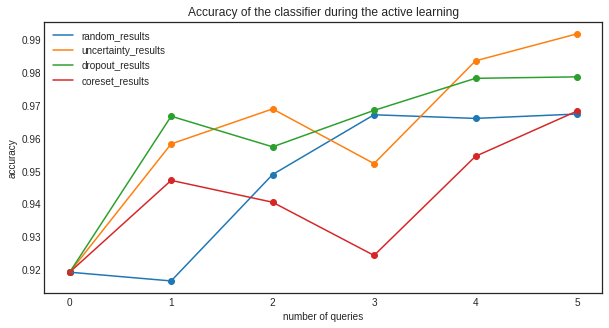

In [24]:
#Result Graph
len_num=len(random_a)
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 5))
    plt.title('Accuracy of the classifier during the active learning')
    plt.plot(np.arange(len_num), random_a, label="random_results")
    plt.scatter(np.arange(len_num), random_a)
    plt.plot(np.arange(len_num), uncertainty_a, label="uncertainty_results")
    plt.scatter(np.arange(len_num), uncertainty_a)
    plt.plot(np.arange(len_num), dropout_a, label="dropout_results")
    plt.scatter(np.arange(len_num), dropout_a)
    plt.plot(np.arange(len_num), coreset_a, label="coreset_results")
    plt.scatter(np.arange(len_num), coreset_a)

    plt.xlabel('number of queries')
    plt.ylabel('accuracy')
    plt.legend(loc="upper left")
    plt.xticks(range(0,len_num))

    ##Saving the plot
    #plt.savefig("isot_acc_111.jpg", bbox_inches='tight')
    plt.show()


In [8]:
#train with train_dataloader: Passing Learning with the entire dataset for comparison
bert_whole=train(train_dataloader, 5) 

2624/2625.0 loss: 0.07089280207259305 


In [9]:
#Passive result - ISOT

results_p=[]
results_r=[]
results_f=[]
results_a=[]

results_p,results_r,results_f,results_a,all_logits=eval_(bert_whole,test_dataloader,results_p,results_r,results_f,results_a,test_y)
print("precision: {0}, recall: {1}, f1: {2}, accuracy:{3}".format(results_p,results_r,results_f,results_a))

1124/2625.0 loss: 0.025281534977173982 
precision: [0.9995066600888012], recall: [0.9945999018163967], f1: [0.9970472440944882], accuracy:[0.9973333333333333]


In [7]:
#Passive result - PolitiFact

results_p=[]
results_r=[]
results_f=[]
results_a=[]

results_p,results_r,results_f,results_a,all_logits=eval_(bert_whole,test_dataloader,results_p,results_r,results_f,results_a,test_y)
print("precision: {0}, recall: {1}, f1: {2}, accuracy:{3}".format(results_p,results_r,results_f,results_a))

583/1361.0 loss: 0.8859679993466882 
precision: [0.8207681365576103], recall: [0.7383237364043506], f1: [0.7773661165375546], accuracy:[0.7167952013710368]


In [9]:
#Passive result - COVID-19 Fake News

results_p=[]
results_r=[]
results_f=[]
results_a=[]

results_p,results_r,results_f,results_a,all_logits=eval_(bert_whole,test_dataloader,results_p,results_r,results_f,results_a,test_y)
print("precision: {0}, recall: {1}, f1: {2}, accuracy:{3}".format(results_p,results_r,results_f,results_a))

793/1851.5 loss: 0.2463634169053287 
precision: [0.9794238683127572], recall: [0.9357798165137615], f1: [0.9571045576407506], accuracy:[0.9596850393700788]


In [8]:
#Passive result - Combined Corpus

results_p=[]
results_r=[]
results_f=[]
results_a=[]

results_p,results_r,results_f,results_a,all_logits=eval_(bert_whole,test_dataloader,results_p,results_r,results_f,results_a,test_y)
print("precision: {0}, recall: {1}, f1: {2}, accuracy:{3}".format(results_p,results_r,results_f,results_a))

1124/2625.0 loss: 0.052896777219764775 
precision: [0.993681550126369], recall: [0.9915931063472047], f1: [0.9926362297496317], accuracy:[0.9922222222222222]


In [9]:
#Passive result - Kaggle Fake News
results_p=[]
results_r=[]
results_f=[]
results_a=[]

results_p,results_r,results_f,results_a,all_logits=eval_(bert_whole,test_dataloader,results_p,results_r,results_f,results_a,test_y)
print("precision: {0}, recall: {1}, f1: {2}, accuracy:{3}".format(results_p,results_r,results_f,results_a))

1124/2625.0 loss: 0.013587774703056008 
precision: [0.9968421052631579], recall: [0.9994722955145119], f1: [0.9981554677206852], accuracy:[0.9984444444444445]


Sample Analysis

In [29]:
#Label Entropy 
def label_entropy(active_y, train_y):
    return sp.stats.entropy([(active_y.sum()/len(active_y)),((len(active_y)-active_y.sum())/len(active_y))],[(train_y.sum()/len(train_y)),((len(train_y)-train_y.sum())/len(train_y))], base=np.e)

#Diversity in Input Space using Jaccard Similarity
def jaccard_similarity(list1, list2):
    intersection = len(set(list1.flat).intersection(list2.flat))
    union = len(set(list1.flat)) + len(set(list2.flat)) - intersection

    return intersection / union

#Diversity in Feature Space using cosine distance
def diversity_f(active_tokens, pool_tokens):
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(active_tokens)
    distances, indices = nbrs.kneighbors(pool_tokens)  
    d=[]
    for i in range(len(pool_tokens)):
        d1=[]
        for j in range(2):
            d1.append(distance.cosine(pool_tokens[i],active_tokens[indices[i][j]]))
        d.append(np.mean(d1))
    return 1-np.mean(d)  

#Representativeness using KNN density 
def representativeness(tokens):
    nbrs = NearestNeighbors(n_neighbors=11, algorithm='ball_tree').fit(tokens)
    distances, indices = nbrs.kneighbors(tokens)
    d=[]
    for i in range(len(tokens)):
        d1=[]
        for j in range(10):
            d1.append(distance.cosine(tokens[i],tokens[indices[i][j+1]]))
        d.append(np.mean(d1))
    return np.mean(d)

#Uncertainty 
def uncertainty_analysis(bert_clf,dataloader):
    bert_clf.eval()
    bert_predicted = []
    all_logits = []
    train_loss = 0
    step_num=0
    with torch.no_grad():
        for step_num, batch_data in enumerate(dataloader):

            token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

            logits = bert_clf(token_ids, masks)
            loss_func = nn.BCELoss()
            loss = loss_func(logits, labels)
            train_loss += loss.item()
            numpy_logits = logits.cpu().detach().numpy()
        
            bert_predicted += list(numpy_logits[:, 0] > 0.5)
            all_logits += list(numpy_logits[:, 0])
            clear_output(wait=True)
            print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(train_data) / BATCH_SIZE, train_loss / (step_num + 1)))
        
    return entropy(all_logits, base=2)/len(all_logits)
    
    

In [30]:
#Running Iteration
def sample_analysis(name,train_tokens_ids,train_y,bert_whole):
    #Loading the saved token data
    _tokens = np.loadtxt(name+'_tokens.txt', dtype=int)
    _y = np.array(np.loadtxt(name+'_y.txt', dtype=int)==1)
    _pool_tokens=np.loadtxt(name+'_pool_tokens.txt', dtype=int)
    _pool_y=np.array(np.loadtxt(name+'_pool_y.txt', dtype=int)==1)
    _masks = np.loadtxt(name+'_masks.txt', dtype=int)
    
    
    #label entropy
    LE=label_entropy(train_y,_y)
    
    #Diversity in Input Space using Jaccard Similarity
    JS=jaccard_similarity(_tokens, _pool_tokens)
    
    #Diversity in Feature space
    DF=diversity_f(_tokens,train_tokens_ids)
    
    #representativeness
    RP=representativeness(_tokens)
    
    #uncertainty
    sample_dataloader=array_to_loader(_tokens,_y,_masks,BATCH_SIZE,SequentialSampler)
    UA=uncertainty_analysis(bert_whole, sample_dataloader)
    return LE,JS,DF,RP,UA

    

al_list=['random','uncertainty','dropout','coreset']

random_=[]
uncertainty_=[]
dropout_=[]
coreset_=[]
al=[random_,uncertainty_,dropout_,coreset_]
for i in range(len(al_list)):
    LE,JS,DF,RP,UA=sample_analysis(al_list[i],train_tokens_ids,train_y,bert_whole)
    al[i].append(LE)
    al[i].append(JS)
    al[i].append(DF)
    al[i].append(RP)
    al[i].append(UA)
print('           Label entropy, Jaccard similarity, Diversity-feature, representativeness, uncertainty analysis')
for i in range(len(al_list)):
    print(al_list[i],':',al[i])

149/2625.0 loss: 0.015667973295821865 
           Label entropy, Jaccard similarity, Diversity-feature, representativeness, uncertainty analysis
random : [0.0032854365554183806, 0.5425133244503664, 0.5049906674520599, 0.552914930166007, 0.013286950795584444]
uncertainty : [0.0630300803142492, 0.5718271152564957, 0.5043358287182218, 0.5516667668644251, 0.014264786820840087]
dropout : [0.0447352495501345, 0.5697035309793471, 0.49925834346420117, 0.5558572833292552, 0.014148992048565161]
coreset : [0.0053136423398853355, 0.6202948034643571, 0.45228795093433116, 0.5744974249693077, 0.013749923505503104]


In [31]:
#making the result to a dataframe

lst2 = [['random']+ random_, 
       ['uncertainty']+uncertainty_,
      ['dropout']+dropout_,
      ['coreset']+coreset_]
df_analysis = pd.DataFrame(lst2, columns =['AL','Label Entropy', 'Diversity-jaccard', 'Diversity-distance', 'Representativeness','Uncertainty'], dtype = float)

#save as csv
#df_analysis.to_csv('isot_sampleacc_111.csv')############################################################################

In [34]:
df_analysis

,AL,Label Entropy,Diversity-jaccard,Diversity-distance,Representativeness,Uncertainty
0,random,0.003285,0.542513,0.504991,0.552915,0.013287
1,uncertainty,0.063030,0.571827,0.504336,0.551667,0.014265
2,dropout,0.044735,0.569704,0.499258,0.555857,0.014149
3,coreset,0.005314,0.620295,0.452288,0.574497,0.013750
